# EEG Quality Control

# Imports

In [1]:
import matplotlib.pyplot as plt
import mne
import numpy as np
import pandas as pd
import pyprep
import pyxdf
from utils import *
from scipy.signal import welch
import warnings
warnings.filterwarnings("ignore")

In [5]:
xdf_filename = '/Users/bryan.gonzalez/CUNY_subs/sub-P5029423/sub-P5029423_ses-S001_task-CUNY_run-001_mobi.xdf'
subject = xdf_filename.split('-')[1].split('/')[0]
df = get_event_data(event='RestingState', 
                    df=import_eeg_data(xdf_filename),
                    stim_df=import_stim_data(xdf_filename))

2025-04-11 10:24:37,842 - pyxdf.pyxdf - INFO - Importing XDF file /Users/bryan.gonzalez/CUNY_subs/sub-P5029423/sub-P5029423_ses-S001_task-CUNY_run-001_mobi.xdf...
2025-04-11 10:24:41,270 - pyxdf.pyxdf - INFO -   performing clock synchronization...
2025-04-11 10:24:41,300 - pyxdf.pyxdf - INFO -   performing jitter removal...
2025-04-11 10:24:41,412 - pyxdf.pyxdf - INFO - Importing XDF file /Users/bryan.gonzalez/CUNY_subs/sub-P5029423/sub-P5029423_ses-S001_task-CUNY_run-001_mobi.xdf...
2025-04-11 10:24:42,947 - pyxdf.pyxdf - INFO -   performing clock synchronization...
2025-04-11 10:24:42,969 - pyxdf.pyxdf - INFO -   performing jitter removal...


# Create MNE Raw Object

In [6]:
## Create MNE Raw object
ch_names = [f"E{i+1}" for i in range(df.shape[1] - 1)]
info = mne.create_info(ch_names, 
                       sfreq=1/df.lsl_time_stamp.diff().mean(), 
                       ch_types='eeg')
df.drop(columns=['lsl_time_stamp'], inplace=True)

raw = mne.io.RawArray(df.T * 1e-6, info=info) # multiplying by 1e-6 converts to volts

# Create a Cz reference
value = np.zeros((1, raw.n_times))
info = mne.create_info(["Cz"], raw.info['sfreq'], ch_types='eeg')
cz = mne.io.RawArray(value, info)
raw.add_channels([cz], force_update_info=True)

# Apply a montage
montage = mne.channels.make_standard_montage('GSN-HydroCel-129')
raw.set_montage(montage, on_missing='ignore')

Creating RawArray with float64 data, n_channels=128, n_times=299995
    Range : 0 ... 299994 =      0.000 ...   300.004 secs
Ready.
Creating RawArray with float64 data, n_channels=1, n_times=299995
    Range : 0 ... 299994 =      0.000 ...   300.004 secs
Ready.


<RawArray | 129 x 299995 (300.0 s), ~295.4 MiB, data loaded>

# Run Automated Processing Pipeline
(this will take some time)

In [7]:
prep_params = {
        "ref_chs": "eeg",
        "reref_chs": "eeg",
        "line_freqs": np.arange(60, raw.info["sfreq"] / 2, 60),
    }
# these params set up the robust reference  - i.e. median of all channels and interpolate bad channels
prep = pyprep.PrepPipeline(raw, montage=montage, channel_wise=True, prep_params=prep_params)
prep_output = prep.fit()
raw_cleaned = prep_output.raw_eeg

NOTE: pick_channels() is a legacy function. New code should use inst.pick(...).
NOTE: pick_types() is a legacy function. New code should use inst.pick(...).
Setting up high-pass filter at 1 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal highpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 1.00
- Lower transition bandwidth: 1.00 Hz (-6 dB cutoff frequency: 0.50 Hz)
- Filter length: 3301 samples (3.301 s)



[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.1s
[Parallel(n_jobs=1)]: Done  71 tasks      | elapsed:    0.3s


Setting up high-pass filter at 1 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal highpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 1.00
- Lower transition bandwidth: 1.00 Hz (-6 dB cutoff frequency: 0.50 Hz)
- Filter length: 3301 samples (3.301 s)



[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.1s
[Parallel(n_jobs=1)]: Done  71 tasks      | elapsed:    0.3s


Removed notch frequencies (Hz):
     60.00 : 7482 windows
    120.00 : 7482 windows
    180.00 : 7482 windows
    239.00 : 7482 windows
    240.00 : 7482 windows
    241.00 : 7482 windows
    299.00 : 7482 windows
    300.00 : 7482 windows
    301.00 : 7482 windows
    359.00 : 7482 windows
    360.00 : 7482 windows
    361.00 : 7482 windows
    419.00 : 7482 windows
    420.00 : 7482 windows
    421.00 : 7482 windows
    479.00 : 7482 windows
    480.00 : 7482 windows
    481.00 : 7482 windows
NOTE: pick_types() is a legacy function. New code should use inst.pick(...).
Setting up high-pass filter at 1 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal highpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 1.00
- Lower transition bandwidth: 1.00 Hz (-6 dB cutoff frequency: 0.50 Hz)
- Filter length: 3301 samples (3.301 s)



[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.1s
[Parallel(n_jobs=1)]: Done  71 tasks      | elapsed:    0.4s


NOTE: pick_types() is a legacy function. New code should use inst.pick(...).
Executing RANSAC
This may take a while, so be patient...
Finding optimal chunk size : 22
Total # of chunks: 6
Current chunk:
1
2
3
4
5
6

RANSAC done!


2025-04-11 10:27:13,829 - pyprep.reference - INFO - Bad channels: {'bad_by_nan': [], 'bad_by_flat': ['Cz'], 'bad_by_deviation': [], 'bad_by_hf_noise': ['E74', 'E76', 'E77', 'E81', 'E82', 'E83', 'E84', 'E88', 'E89', 'E90', 'E94', 'E95'], 'bad_by_correlation': ['E128'], 'bad_by_SNR': [], 'bad_by_dropout': [], 'bad_by_ransac': [np.str_('E7'), np.str_('E88'), np.str_('E106'), np.str_('E126'), np.str_('E127')], 'bad_all': [np.str_('E127'), 'E77', 'E82', 'E89', 'E95', 'E76', 'E94', 'E81', np.str_('E7'), 'Cz', 'E88', np.str_('E106'), 'E84', 'E128', np.str_('E126'), 'E83', 'E90', 'E74']}


NOTE: pick_types() is a legacy function. New code should use inst.pick(...).
Executing RANSAC
This may take a while, so be patient...
Finding optimal chunk size : 31
Total # of chunks: 4
Current chunk:
1
2
3
4

RANSAC done!


2025-04-11 10:28:06,453 - pyprep.reference - INFO - Bad channels: {'bad_by_nan': [], 'bad_by_flat': ['Cz'], 'bad_by_deviation': ['E25', 'E128', 'E88', 'E8'], 'bad_by_hf_noise': ['E77', 'E89', 'E95', 'E94', 'E81', 'E88', 'E84', 'E90', 'E74'], 'bad_by_correlation': ['E128', 'E88'], 'bad_by_SNR': ['E88'], 'bad_by_dropout': [], 'bad_by_ransac': [np.str_('E63'), np.str_('E126')], 'bad_all': ['E77', 'E89', 'E95', 'E94', 'E81', np.str_('E63'), 'E88', 'Cz', 'E84', 'E128', np.str_('E126'), 'E8', 'E90', 'E74', 'E25']}


Setting channel interpolation method to {'eeg': 'spline'}.
Interpolating bad channels.
    Automatic origin fit: head of radius 94.0 mm
Computing interpolation matrix from 114 sensor positions
Interpolating 15 sensors


2025-04-11 10:28:07,164 - pyprep.reference - INFO - Iterations: 1


NOTE: pick_types() is a legacy function. New code should use inst.pick(...).
Executing RANSAC
This may take a while, so be patient...
Finding optimal chunk size : 42
Total # of chunks: 3
Current chunk:
1
2
3

RANSAC done!


2025-04-11 10:29:38,467 - pyprep.reference - INFO - Bad channels: {'bad_by_nan': [], 'bad_by_flat': ['Cz'], 'bad_by_deviation': ['E8', 'E128', 'E88', 'E25'], 'bad_by_hf_noise': ['E77', 'E89', 'E95', 'E94', 'E81', 'E88', 'E84', 'E90', 'E74'], 'bad_by_correlation': ['E128', 'E88'], 'bad_by_SNR': ['E88'], 'bad_by_dropout': [], 'bad_by_ransac': [np.str_('E63'), np.str_('E126')], 'bad_all': ['E77', 'E89', 'E95', 'E94', 'E81', np.str_('E63'), 'E88', 'Cz', 'E84', 'E128', np.str_('E126'), 'E8', 'E90', 'E74', 'E25']}


Setting channel interpolation method to {'eeg': 'spline'}.
Interpolating bad channels.
    Automatic origin fit: head of radius 94.0 mm
Computing interpolation matrix from 114 sensor positions
Interpolating 15 sensors


2025-04-11 10:29:39,039 - pyprep.reference - INFO - Iterations: 2


NOTE: pick_types() is a legacy function. New code should use inst.pick(...).
Executing RANSAC
This may take a while, so be patient...
Finding optimal chunk size : 42
Total # of chunks: 3
Current chunk:
1
2
3

RANSAC done!


2025-04-11 10:30:31,054 - pyprep.reference - INFO - Bad channels: {'bad_by_nan': [], 'bad_by_flat': ['Cz'], 'bad_by_deviation': ['E25', 'E128', 'E88', 'E8'], 'bad_by_hf_noise': ['E77', 'E89', 'E95', 'E94', 'E81', 'E88', 'E84', 'E90', 'E74'], 'bad_by_correlation': ['E128', 'E88'], 'bad_by_SNR': ['E88'], 'bad_by_dropout': [], 'bad_by_ransac': [np.str_('E63'), np.str_('E126')], 'bad_all': ['E77', 'E89', 'E95', 'E94', 'E81', np.str_('E63'), 'E88', 'Cz', 'E84', 'E128', np.str_('E126'), 'E8', 'E90', 'E74', 'E25']}
2025-04-11 10:30:31,054 - pyprep.reference - INFO - Robust reference done


Setting channel interpolation method to {'eeg': 'spline'}.
Interpolating bad channels.
    Automatic origin fit: head of radius 94.0 mm
Computing interpolation matrix from 114 sensor positions
Interpolating 15 sensors
NOTE: pick_types() is a legacy function. New code should use inst.pick(...).
Setting up high-pass filter at 1 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal highpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 1.00
- Lower transition bandwidth: 1.00 Hz (-6 dB cutoff frequency: 0.50 Hz)
- Filter length: 3301 samples (3.301 s)



[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.1s
[Parallel(n_jobs=1)]: Done  71 tasks      | elapsed:    0.4s


Executing RANSAC
This may take a while, so be patient...
Finding optimal chunk size : 63
Total # of chunks: 2
Current chunk:
1
2

RANSAC done!
Found 14 uniquely bad channels:

0 by NaN: []

0 by flat: []

4 by deviation: ['E8', 'E25', 'E88', 'E128']

9 by HF noise: ['E74', 'E77', 'E81', 'E84', 'E88', 'E89', 'E90', 'E94', 'E95']

2 by correlation: ['E88', 'E128']

1 by SNR: ['E88']

0 by dropout: []

2 by RANSAC: [np.str_('E1'), np.str_('E126')]

Setting channel interpolation method to {'eeg': 'spline'}.
Interpolating bad channels.
    Automatic origin fit: head of radius 94.0 mm
Computing interpolation matrix from 114 sensor positions
Interpolating 15 sensors
NOTE: pick_types() is a legacy function. New code should use inst.pick(...).
Setting up high-pass filter at 1 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal highpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband at

[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.1s
[Parallel(n_jobs=1)]: Done  71 tasks      | elapsed:    0.3s


Executing RANSAC
This may take a while, so be patient...
Finding optimal chunk size : 64
Total # of chunks: 2
Current chunk:
1
2

RANSAC done!


In [8]:
print(f"Bad channels before robust reference: {prep.noisy_channels_original['bad_all']}")
print(f"Interpolated channels: {prep.interpolated_channels}")
print(f"Bad channels after interpolation: {prep.still_noisy_channels}")


Bad channels before robust reference: [np.str_('E127'), 'E77', 'E82', 'E89', 'E95', 'E76', 'E94', 'E81', np.str_('E7'), 'Cz', 'E88', np.str_('E106'), 'E84', 'E128', np.str_('E126'), 'E83', 'E90', 'E74']
Interpolated channels: ['E77', 'E89', 'E95', 'E94', 'E81', 'E88', 'Cz', 'E84', 'E128', np.str_('E126'), 'E8', 'E25', 'E90', 'E74', np.str_('E1')]
Bad channels after interpolation: ['E73', 'E82', np.str_('E119'), 'E63']


# Plot PSD

NOTE: plot_psd() is a legacy function. New code should use .compute_psd().plot().
Effective window size : 2.048 (s)
Plotting power spectral density (dB=True).


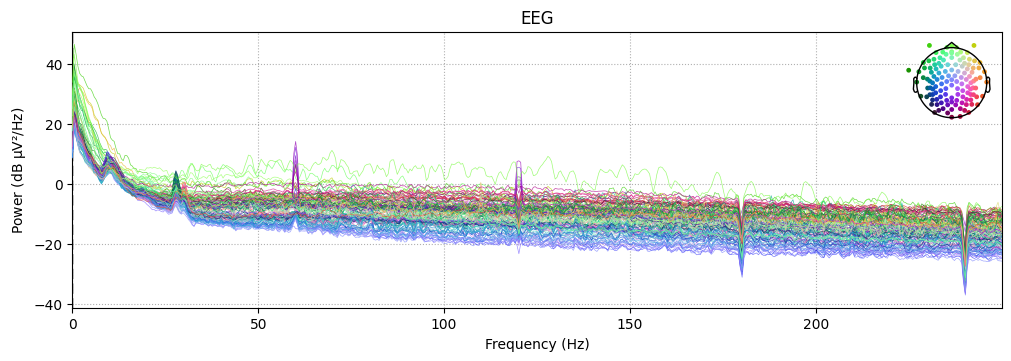

In [9]:
fig = raw_cleaned.plot_psd(tmax=np.inf, fmax=250)
# add some arrows at 60 Hz and its harmonics:
'''
for ax in fig.axes[:2]:
    freqs = ax.lines[-1].get_xdata()
    psds = ax.lines[-1].get_ydata()
    for freq in (60, 120, 180, 240):
        idx = np.searchsorted(freqs, freq)
        ax.arrow(x=freqs[idx], y=psds[idx] + 18, dx=0, dy=-12, color='red',
                 width=0.1, head_width=3, length_includes_head=True)
        
'''
fig.savefig(f'report_images/{subject}_eeg_psd.png')

# Annotation Blinks and Muscle Artifacts

In [10]:
def annotate_blinks(
    raw: mne.io.Raw, ch_name: list[str] = ["E25", "E8"]
) -> mne.Annotations:
    """Annotate the blinks in the EEG signal.
 
    Args:
        raw (mne.io.Raw): The raw EEG data in mne format.
        ch_name (list[str]): The channels to use for the EOG. Default is
                             ["Fp1", "Fp2"]. I would suggest to use the
                             channels that are the most frontal (just above
                             the eyes). In the case of an EGI system the
                             channels would be "E25" and "E8".
 
    Returns:
        mne.Annotations: The annotations object containing the blink events.
    """
    eog_epochs = mne.preprocessing.create_eog_epochs(raw, ch_name=ch_name)
    blink_annotations = mne.annotations_from_events(
        eog_epochs.events,
        raw.info["sfreq"],
        event_desc={eog_epochs.events[0, 2]: "blink"},
    )
    return blink_annotations

def annotate_muscle(raw: mne.io.Raw) -> mne.Annotations:
    muscle_annotations, _ = mne.preprocessing.annotate_muscle_zscore(
        raw, 
        threshold=3, # this needs to be calibrated for the entire dataset
        ch_type='eeg', 
        min_length_good=0.1, 
        filter_freq=(95, 120), 
        )
 
    return muscle_annotations

In [11]:
fig = raw_cleaned.plot(show_scrollbars=False,
                       show_scalebars=False,events=None, start=0, duration=300,n_channels=75, scalings=11e-5,color='k')
fig.grab().save(f'report_images/{subject}_eeg_annotations.png')

2025-04-11 10:53:29,075 - OpenGL.acceleratesupport - INFO - No OpenGL_accelerate module loaded: No module named 'OpenGL_accelerate'


Using qt as 2D backend.
Using pyopengl with version 3.1.7


True

In [12]:
# Applying a high pass filter to remove low frequency noise
raw_cleaned.filter(l_freq=0.5, h_freq=None)

blink_annotations = annotate_blinks(raw_cleaned, ch_name=["E25", "E8"])

muscle_annotations = annotate_muscle(raw_cleaned)

all_annotations = blink_annotations + muscle_annotations + raw.annotations
raw_cleaned.set_annotations(all_annotations)

Filtering raw data in 1 contiguous segment
Setting up high-pass filter at 0.5 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal highpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 0.50
- Lower transition bandwidth: 0.50 Hz (-6 dB cutoff frequency: 0.25 Hz)
- Filter length: 6601 samples (6.601 s)



[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.1s
[Parallel(n_jobs=1)]: Done  71 tasks      | elapsed:    0.3s


Using EOG channels: E25, E8
EOG channel index for this subject is: [24  7]
Filtering the data to remove DC offset to help distinguish blinks from saccades
Selecting channel E8 for blink detection
Setting up band-pass filter from 1 - 10 Hz

FIR filter parameters
---------------------
Designing a two-pass forward and reverse, zero-phase, non-causal bandpass filter:
- Windowed frequency-domain design (firwin2) method
- Hann window
- Lower passband edge: 1.00
- Lower transition bandwidth: 0.50 Hz (-12 dB cutoff frequency: 0.75 Hz)
- Upper passband edge: 10.00 Hz
- Upper transition bandwidth: 0.50 Hz (-12 dB cutoff frequency: 10.25 Hz)
- Filter length: 10000 samples (10.000 s)

Now detecting blinks and generating corresponding events
Found 107 significant peaks
Number of EOG events detected: 107
Not setting metadata
107 matching events found
No baseline correction applied
Using data from preloaded Raw for 107 events and 1001 original time points ...
1 bad epochs dropped
Filtering raw data i

[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.1s
[Parallel(n_jobs=1)]: Done  71 tasks      | elapsed:    0.5s


Setting up low-pass filter at 4 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal lowpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Upper passband edge: 4.00 Hz
- Upper transition bandwidth: 2.00 Hz (-6 dB cutoff frequency: 5.00 Hz)
- Filter length: 1651 samples (1.651 s)



<RawArray | 129 x 299995 (300.0 s), ~295.4 MiB, data loaded>

## Computing % Good Data

In [13]:
# Create a binary array
binary_mask = np.zeros(len(raw_cleaned.times), dtype=int)

# Iterate over annotations
for annot in raw_cleaned.annotations:
    onset_sample = int(annot['onset'] * raw_cleaned.info['sfreq'])
    duration_sample = int(annot['duration'] * raw_cleaned.info['sfreq'])
    binary_mask[onset_sample:onset_sample + duration_sample] = 1

percent_good = 1 - np.sum(binary_mask) / len(binary_mask)
print(f'Percent Good Data: {percent_good * 100:.2f}%')

Percent Good Data: 89.75%


In [14]:
(1 - percent_good)*100

np.float64(10.251504191736526)

NOTE: plot_psd() is a legacy function. New code should use .compute_psd().plot().
Setting 30816 of 299995 (10.27%) samples to NaN, retaining 269179 (89.73%) samples.
Effective window size : 2.048 (s)
At least one good data span is shorter than n_per_seg, and will be analyzed with a shorter window than the rest of the file.
Plotting power spectral density (dB=True).


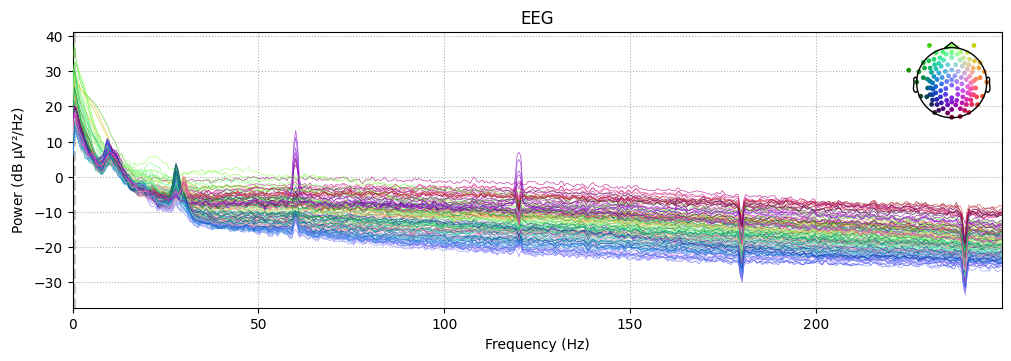

In [15]:
raw_cleaned.plot_psd(tmax=np.inf, fmax=250)

## Quantifying Blinks and Muscle Artifacts through ICA

In [16]:
#filt_raw = raw.copy().filter(l_freq=1.0, h_freq=None)
filt_raw = raw_cleaned.copy()
filt_raw.info['bads'] = prep.still_noisy_channels 
ica = mne.preprocessing.ICA(n_components=.99, method='picard')
ica.fit(filt_raw)
#ica.plot_sources(filt_raw)


Fitting ICA to data using 125 channels (please be patient, this may take a while)
Omitting 30816 of 299995 (10.27%) samples, retaining 269179 (89.73%) samples.
Selecting by explained variance: 22 components
Fitting ICA took 12.2s.


Method,picard
Fit parameters,max_iter=500
Fit,64 iterations on raw data (269179 samples)
ICA components,22
Available PCA components,125
Channel types,eeg
ICA components marked for exclusion,—


In [17]:
ica.plot_sources(filt_raw)

Creating RawArray with float64 data, n_channels=22, n_times=299995
    Range : 0 ... 299994 =      0.000 ...   300.004 secs
Ready.
Using pyopengl with version 3.1.7


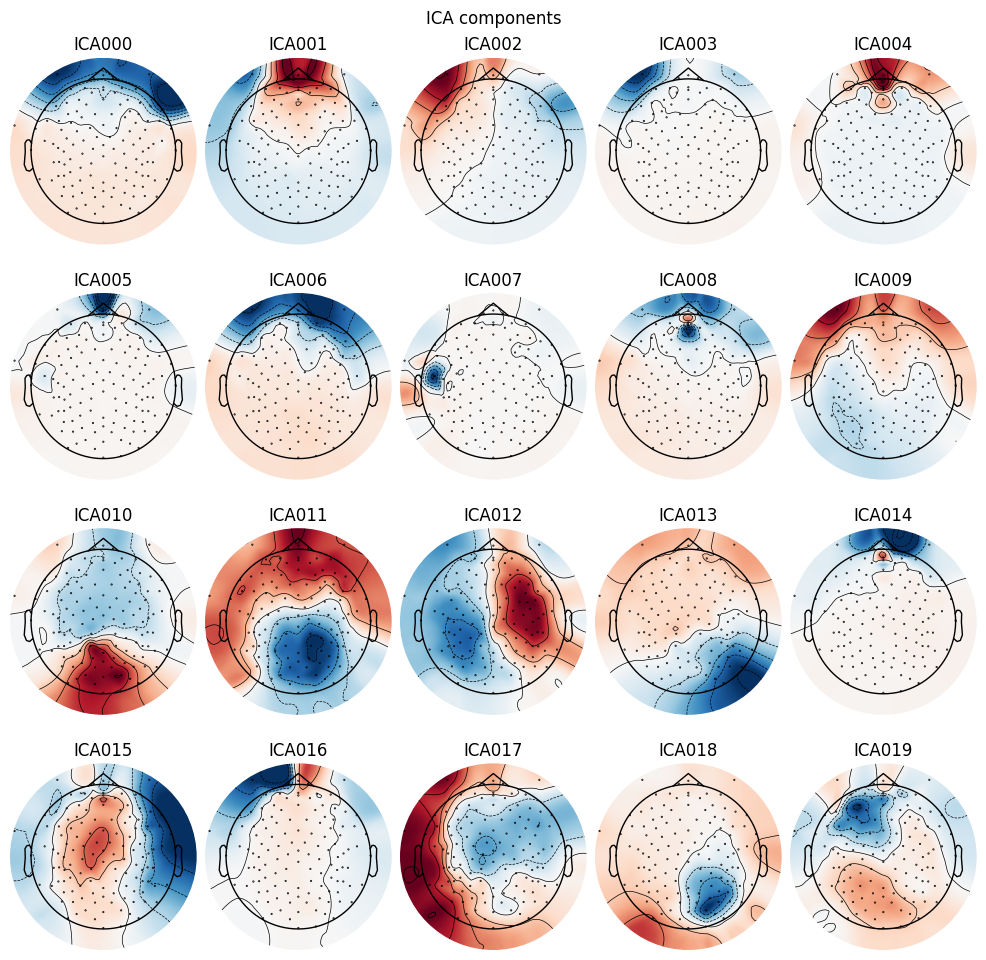

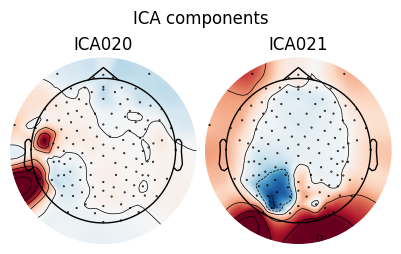

In [19]:
ica.plot_components()#.savefig(f'report_images/{subject}_ica_components.png')
# save the figure
plt.savefig(f'report_images/{subject}_ica_components.png')

In [16]:
comp_idx, scores = ica.find_bads_muscle(filt_raw)

# Remove the muscle artifacts
raw_ica = ica.apply(filt_raw, exclude=comp_idx)

Setting 30192 of 299995 (10.06%) samples to NaN, retaining 269803 (89.94%) samples.
Effective window size : 2.048 (s)
At least one good data span is shorter than n_per_seg, and will be analyzed with a shorter window than the rest of the file.
Applying ICA to Raw instance
    Transforming to ICA space (26 components)
    Zeroing out 1 ICA component
    Projecting back using 126 PCA components


# Ocular Artifacts

Using EOG channels: E8, E25
EOG channel index for this subject is: [ 7 24]
Omitting 30192 of 299995 (10.06%) samples, retaining 269803 (89.94%) samples.
Filtering the data to remove DC offset to help distinguish blinks from saccades
Selecting channel E8 for blink detection
Setting up band-pass filter from 1 - 10 Hz

FIR filter parameters
---------------------
Designing a two-pass forward and reverse, zero-phase, non-causal bandpass filter:
- Windowed frequency-domain design (firwin2) method
- Hann window
- Lower passband edge: 1.00
- Lower transition bandwidth: 0.50 Hz (-12 dB cutoff frequency: 0.75 Hz)
- Upper passband edge: 10.00 Hz
- Upper transition bandwidth: 0.50 Hz (-12 dB cutoff frequency: 10.25 Hz)
- Filter length: 10000 samples (10.000 s)

Now detecting blinks and generating corresponding events
Found 74 significant peaks
Number of EOG events detected: 74
Not setting metadata
74 matching events found
No baseline correction applied
Using data from preloaded Raw for 74 events a

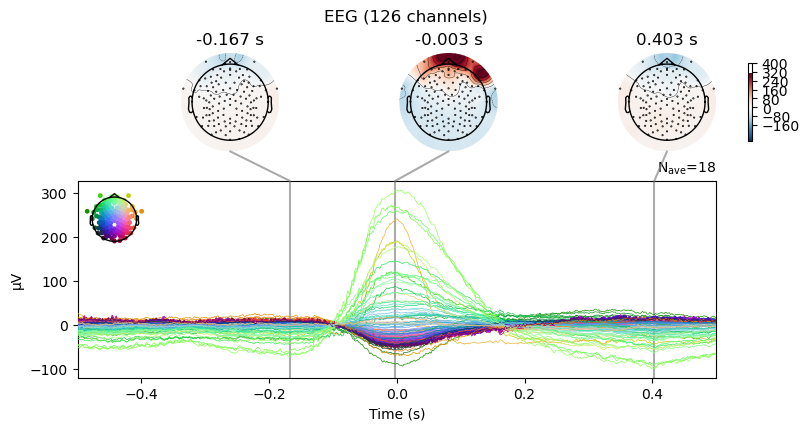

In [17]:
eog_evoked = mne.preprocessing.create_eog_epochs(raw_cleaned, ch_name=['E8', 'E25']).average(picks="all")
eog_evoked.apply_baseline((None, None))
eog_evoked.plot_joint().savefig(f'report_images/{subject}_eog_evoked.png')

In [18]:
eog_projs, _ = mne.preprocessing.compute_proj_eog(raw_cleaned, n_eeg=1, reject=None, no_proj=True,
                                                  ch_name=['E8', 'E25'])


Running EOG SSP computation
Using EOG channels: E8, E25
EOG channel index for this subject is: [ 7 24]
Filtering the data to remove DC offset to help distinguish blinks from saccades
Selecting channel E8 for blink detection
Setting up band-pass filter from 1 - 10 Hz

FIR filter parameters
---------------------
Designing a two-pass forward and reverse, zero-phase, non-causal bandpass filter:
- Windowed frequency-domain design (firwin2) method
- Hann window
- Lower passband edge: 1.00
- Lower transition bandwidth: 0.50 Hz (-12 dB cutoff frequency: 0.75 Hz)
- Upper passband edge: 10.00 Hz
- Upper transition bandwidth: 0.50 Hz (-12 dB cutoff frequency: 10.25 Hz)
- Filter length: 10000 samples (10.000 s)

Now detecting blinks and generating corresponding events
Found 99 significant peaks
Number of EOG events detected: 99
Computing projector
Filtering a subset of channels. The highpass and lowpass values in the measurement info will not be updated.
Filtering raw data in 1 contiguous segment


[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.2s
[Parallel(n_jobs=1)]: Done  71 tasks      | elapsed:    0.8s


Not setting metadata
99 matching events found
No baseline correction applied
0 projection items activated
Using data from preloaded Raw for 99 events and 401 original time points ...
68 bad epochs dropped
No channels 'grad' found. Skipping.
No channels 'mag' found. Skipping.
Adding projection: eeg--0.200-0.200-PCA-01 (exp var=96.3%)
Done.


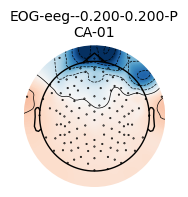

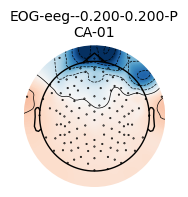

In [19]:
mne.viz.plot_projs_topomap(eog_projs, info=raw.info)

In [ ]:
fig = mne.viz.plot_projs_joint(eog_projs, eog_evoked,['E8', 'E25'] )
fig.suptitle("EOG projectors");

In [ ]:
filt_raw.add_proj(eog_projs)
filt_raw.plot()

In [ ]:
fig = raw_cleaned.plot_psd(tmax=np.inf, fmax=250)
# apply a notch filter to remove 60 Hz noise
raw_cleaned.notch_filter(np.arange(60, 241, 60), filter_length='auto', phase='zero')
fig = raw_cleaned.plot_psd(tmax=np.inf, fmax=250)

In [ ]:
#perform an autocorrelation of a single channel
fig, ax = plt.subplots()
ax.acorr(raw_cleaned.get_data()[0], maxlags=1000)
ax.set_xlim([0, 1000])  # only show the first 1000 lags
ax.set_title('Autocorrelation of Channel 1')
# without plotting


In [ ]:
autocorr = np.correlate(raw_cleaned.get_data()[0], raw_cleaned.get_data()[0], mode='full')

# Peak-to-Peak Amplitude

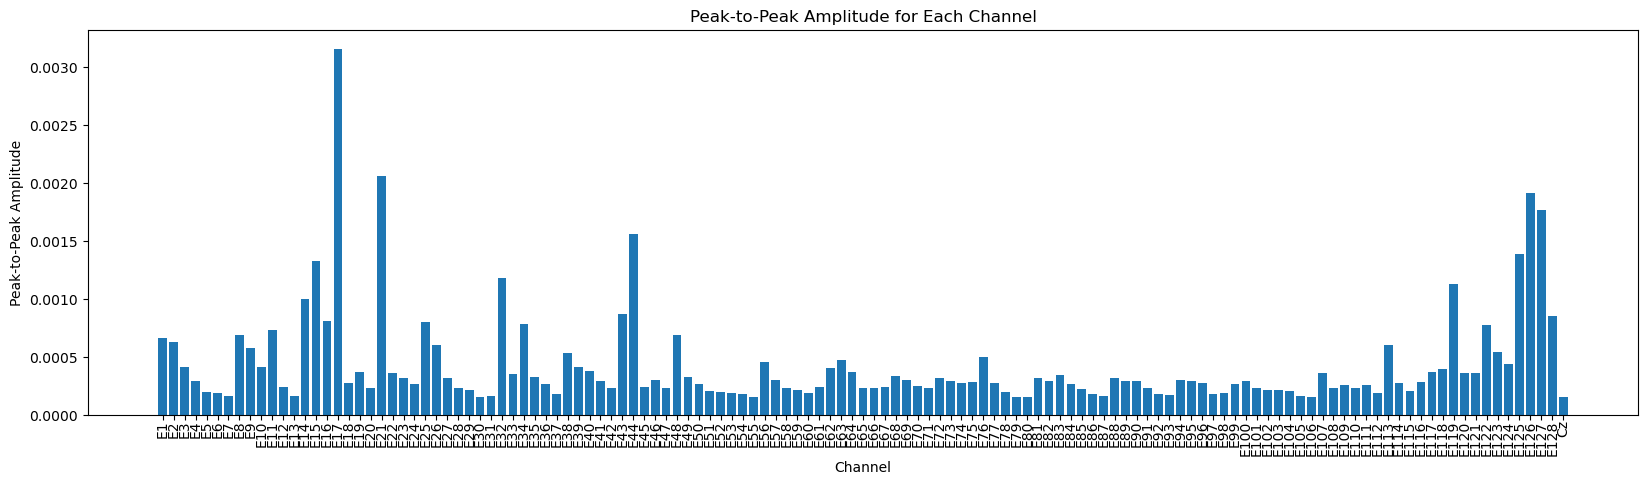

In [20]:
sensor_ptp = [np.ptp(filt_raw.get_data()[i]) for i in range(len(raw_cleaned.get_data()))]
f, ax = plt.subplots(figsize=(20, 5))
plt.bar(raw_cleaned.ch_names, sensor_ptp)
plt.xlabel('Channel')
# rotate xticks
plt.xticks(rotation=90 )
ax.tick_params(axis='x',  pad=0)
plt.ylabel('Peak-to-Peak Amplitude')
plt.title('Peak-to-Peak Amplitude for Each Channel')
plt.show()


In [ ]:
np.median(sensor_ptp)

In [ ]:
raw_cleaned.plot()

# Standard Deviation of Amplitude

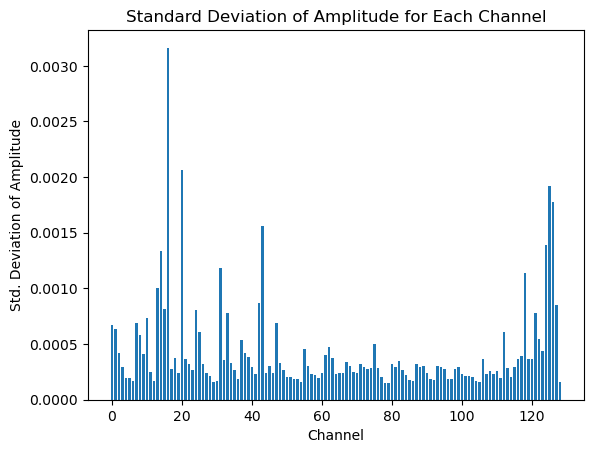

In [21]:
# Compute Standard Deviation of Amplitude for each Channel
sensor_std = [np.std(raw_cleaned.get_data()[i]) for i in range(len(raw_cleaned.get_data()))]
plt.bar(range(len(sensor_ptp)), sensor_ptp)
plt.xlabel('Channel')
plt.ylabel('Std. Deviation of Amplitude')
plt.title('Standard Deviation of Amplitude for Each Channel')
plt.show()

In [ ]:
np.median(sensor_std)

NOTE: plot_psd() is a legacy function. New code should use .compute_psd().plot().
Setting 30192 of 299995 (10.06%) samples to NaN, retaining 269803 (89.94%) samples.
Effective window size : 2.048 (s)
At least one good data span is shorter than n_per_seg, and will be analyzed with a shorter window than the rest of the file.
Plotting power spectral density (dB=True).


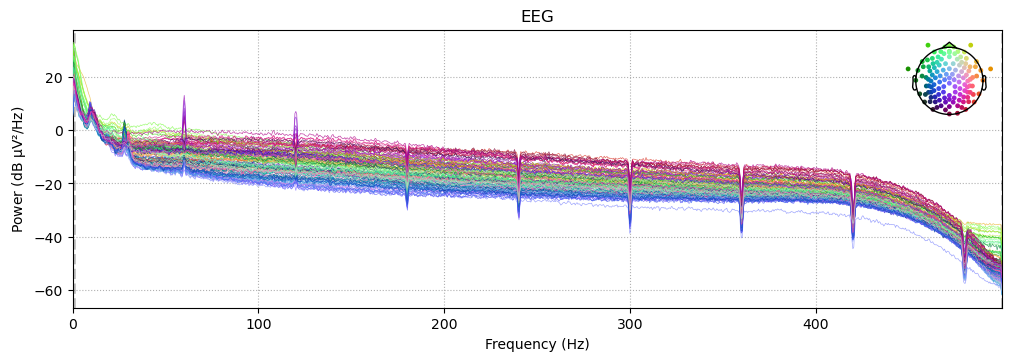

In [22]:
filt_raw.plot_psd()

# Power in 60Hz Noise Frequency

In [23]:
psds, freqs = mne.time_frequency.psd_array_welch(
    raw_cleaned.get_data(), 
    sfreq=raw_cleaned.info['sfreq'],
    fmin=59, 
    fmax=61,  # A small band around 60 Hz to capture power
    n_fft=2048,  # Adjust the window length for better frequency resolution
    verbose=False
)

In [24]:
mean_power_60hz = psds.mean(axis=0).mean()  # Mean across channels and frequency bins
print(f"Mean power at 60 Hz: {mean_power_60hz:.4e} V²/Hz")

Mean power at 60 Hz: 5.0404e-13 V²/Hz


In [26]:
signal_power = np.mean(raw_cleaned._data ** 2, axis=1)
signal_power = signal_power.mean()

# Calculate SNR in dB
snr = 10 * np.log10(signal_power / mean_power_60hz)

Effective window size : 0.256 (s)


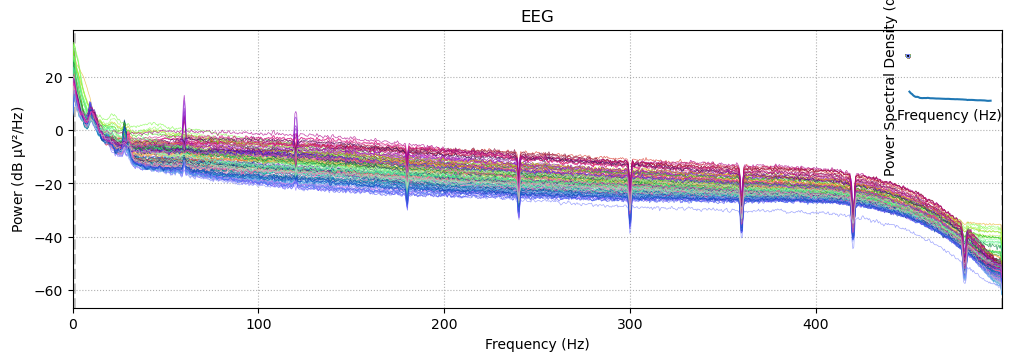

"\nidx_60hz = (freqs > 59) & (freqs < 61)\npower_60hz = psds[idx_60hz].mean(axis=1)\n\nnoise = {}\nfor ch, power in zip(raw_cleaned.ch_names, power_60hz):\n    noise[ch] = power\n    print(f' Channel {ch}: Power at  60Hz:{power:.2f} dB')\n"

In [27]:
psds, freqs = mne.time_frequency.psd_array_welch(raw_cleaned.get_data(), sfreq=raw_cleaned.info['sfreq'], fmin=0.5, fmax=250)
psds = 10 * np.log10(psds)
plt.plot(freqs, psds.mean(axis=0))
plt.xlabel('Frequency (Hz)')
plt.ylabel('Power Spectral Density (dB)')
plt.show()
'''
idx_60hz = (freqs > 59) & (freqs < 61)
power_60hz = psds[idx_60hz].mean(axis=1)

noise = {}
for ch, power in zip(raw_cleaned.ch_names, power_60hz):
    noise[ch] = power
    print(f' Channel {ch}: Power at  60Hz:{power:.2f} dB')
'''

NOTE: plot_psd() is a legacy function. New code should use .compute_psd().plot().
Setting 30192 of 299995 (10.06%) samples to NaN, retaining 269803 (89.94%) samples.
Effective window size : 2.048 (s)
At least one good data span is shorter than n_per_seg, and will be analyzed with a shorter window than the rest of the file.
Plotting power spectral density (dB=True).


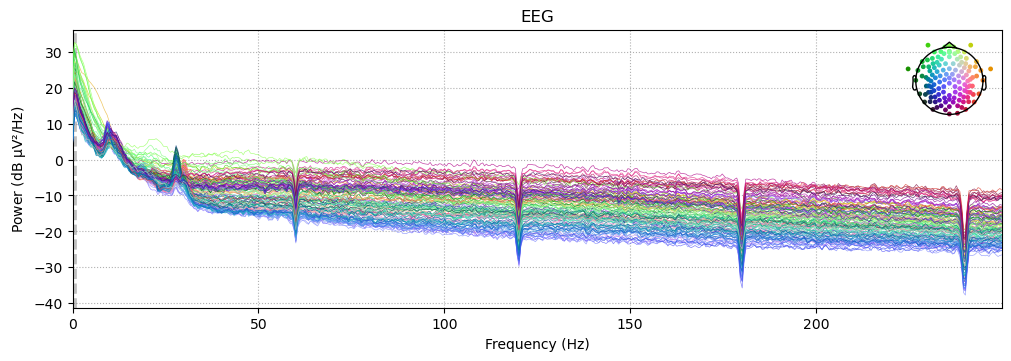

In [30]:
#apply a weak notch filter to remove 60 Hz noise
#raw_cleaned.notch_filter(np.arange(60, 241, 60), filter_length='auto', phase='zero')
raw_cleaned.plot_psd(tmax=np.inf, fmax=250)

In [ ]:
freq_min = 59
freq_max = 61
# Apply a bandpass filter to the data
raw_filtered = raw_cleaned.filter(freq_min, freq_max)
psds, freqs = mne.time_frequency.psd_array_welch(raw_filtered.get_data(), sfreq=raw_filtered.info['sfreq'], fmin=freq_min, fmax=freq_max, n_fft=2048)

# Extract the power at 60 Hz
idx_60hz = (freqs >= 60 - 0.5) & (freqs <= 60 + 0.5)
power_60hz = psds[:, idx_60hz].mean(axis=1)
noise = {}
# Print the power at 60 Hz for each channel
for ch_name, power in zip(raw.ch_names, power_60hz):
    noise[ch_name] = power
    print(f'Channel {ch_name}: Power at 60 Hz = {power:.2e} µV²/Hz')

In [ ]:
noises = [noise[ch] for ch in raw.ch_names]
noise_df = pd.DataFrame({'Channel':list(noise.keys()), 'Noise Power (dB)': noise.values()})
plt.subplots(figsize=(30, 5))
plt.plot(noise_df['Channel'], noise_df['Noise Power (dB)'])
plt.xlabel('Channel')
# fix spacing of the xticks
plt.xticks(rotation=90)
plt.ylabel('Noise Power (dB)')          
plt.title('Noise Power at 60 Hz for Each Channel')
plt.show()

In [ ]:
# Compute power of the signal and noise
signal_power = np.mean(raw_cleaned._data ** 2, axis=1)
noise_power = np.mean([n**2 for n in noises])

# Calculate SNR in dB
snr = 10 * np.log10(signal_power / noise_power)

In [ ]:
# square each value of noise
plt.plot(snr)
plt.xlabel('Channel')
plt.ylabel('SNR (dB)')
plt.title('Signal-to-Noise Ratio for Each Channel')
plt.show()

In [ ]:
np.mean(snr)

# Alpha Band Power

In [31]:
freq_min = 8
freq_max = 12
# Apply a bandpass filter to the data
raw_filtered = raw_cleaned.filter(freq_min, freq_max)
psds, freqs = mne.time_frequency.psd_array_welch(raw_filtered.get_data(), sfreq=raw_filtered.info['sfreq'], fmin=freq_min, fmax=freq_max, n_fft=2048)


Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 8 - 12 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 8.00
- Lower transition bandwidth: 2.00 Hz (-6 dB cutoff frequency: 7.00 Hz)
- Upper passband edge: 12.00 Hz
- Upper transition bandwidth: 3.00 Hz (-6 dB cutoff frequency: 13.50 Hz)
- Filter length: 1651 samples (1.651 s)



[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.1s
[Parallel(n_jobs=1)]: Done  71 tasks      | elapsed:    0.6s


Effective window size : 2.048 (s)


In [37]:
psds.sum(axis=1).sum()
# convert to non-scienfic notation
psds = 10 * np.log10(psds)
psds = psds.mean(axis=1).sum()
print(f"Total power in the alpha band: {psds:.4e} V²/Hz")

Total power in the alpha band: -1.4820e+04 V²/Hz


NOTE: plot_psd() is a legacy function. New code should use .compute_psd().plot().
Setting 30192 of 299995 (10.06%) samples to NaN, retaining 269803 (89.94%) samples.
Effective window size : 2.048 (s)
At least one good data span is shorter than n_per_seg, and will be analyzed with a shorter window than the rest of the file.
Plotting power spectral density (dB=True).


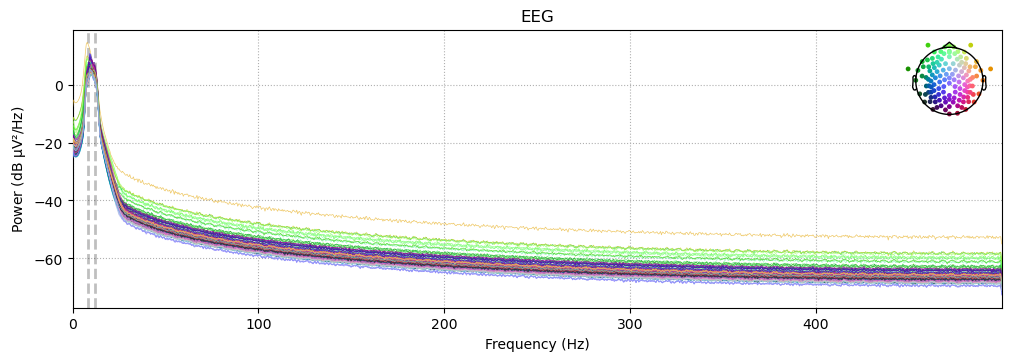

In [38]:
raw_cleaned.plot_psd()